In [1]:
# !pip install pytorch-tabnet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

In [3]:
# 평가 기준 생성
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

In [4]:
train = pd.read_csv("./train.csv")
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [5]:
data_test = pd.read_csv("./test.csv")
data_test.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,0,1979,Graduation,Single,57537.0,1,0,10-06-2013,83,4,...,3,8,4,0,0,0,0,0,0,0
1,1,1955,Graduation,Together,65748.0,0,1,15-04-2013,58,2,...,4,10,1,0,0,0,0,0,1,0
2,2,1984,Graduation,Married,55434.0,1,0,05-10-2013,21,3,...,3,13,4,0,0,0,0,0,0,0
3,3,1960,Graduation,Married,67716.0,0,1,10-01-2013,8,4,...,4,13,5,0,1,0,0,0,0,0
4,4,1976,Graduation,Together,85606.0,0,1,12-11-2012,89,2,...,7,9,3,0,0,0,1,0,0,0


#### train.csv : 학습 데이터
- id : 샘플 아이디
- Year_Birth : 고객 생년월일
- Education : 고객 학력
- Marital_status : 고객 결혼 상태
- Income : 고객 연간 가구 소득
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수
- NumDealsPurchases : 할인된 구매 횟수
- NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases : 카탈로그를 사용한 구매 수 
- NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량

In [6]:
train.shape

(1108, 22)

In [7]:
train.info()
# 범주형 data : Education, Marital_Status, Dt_Customer
# AcceptedCmp, Complain, Response는 0 or 1 이진값

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

<AxesSubplot:xlabel='target', ylabel='Count'>

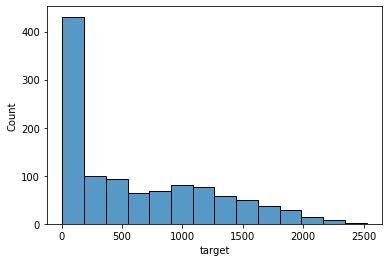

In [8]:
# target 관찰
sns.histplot(train["target"])

In [9]:
# Dt_Customer 숫자형으로 변경
def seperate_datetime(dataframe):
    year = list()
    month = list()
    day = list()
    
    for data in dataframe.Dt_Customer:
        day_point, month_point, year_point = data.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)

# 1년은 365일, 한달은 30일로 균일화
# year = [2022 - item for item in year]
# pastDate = [item[0]*12 + item[1] for item in zip(year, month)]

# print(year[:10])
# print(month[:10])
# print(day[:10])
# print(pastDate[:10])

# train["pastDate"] = pastDate
# train["year"] = year
# train["month"] = month
# train["day"] = day

# train.drop(["Dt_Customer"], axis=1, inplace=True)

# train.head()

In [10]:
# year, month, day = seperate_datetime(data_test)

# year = [2022 - item for item in year]
# pastDate = [item[0]*12 + item[1] for item in zip(year, month)]

# print(year[:10])
# print(month[:10])
# print(day[:10])
# print(pastDate[:10])

# data_test["pastDate"] = pastDate
# data_test["year"] = year
# data_test["month"] = month
# data_test["day"] = day

# data_test.drop(["Dt_Customer"], axis=1, inplace=True)

# data_test.head()

In [11]:
# 날짜 데이터 변경
train["Dt_Customer"] = pd.to_datetime(train["Dt_Customer"], format="%d-%m-%Y")
data_test["Dt_Customer"] = pd.to_datetime(data_test["Dt_Customer"], format="%d-%m-%Y")

train_diff_date = train["Dt_Customer"] - train["Dt_Customer"].min()
data_test_diff_date = data_test["Dt_Customer"] - data_test["Dt_Customer"].min()

train["pastDate"] = [idx.days for idx in train_diff_date]
data_test["pastDate"] = [idx.days for idx in data_test_diff_date]

train.drop(["Dt_Customer"], axis=1, inplace=True)
data_test.drop(["Dt_Customer"], axis=1, inplace=True)

train["pastDate"].head()

0    174
1    662
2    251
3    606
4    679
Name: pastDate, dtype: int64

In [12]:
# feature를 카테고리형과 수치형으로 분할
categorical = ["Education", "Marital_Status", "Kidhome", "Teenhome",
              "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5",
              "Complain", "Response"]

quantitative = ["Year_Birth", "Income", "pastDate", "Recency", "NumDealsPurchases", "NumWebPurchases",
               "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"]

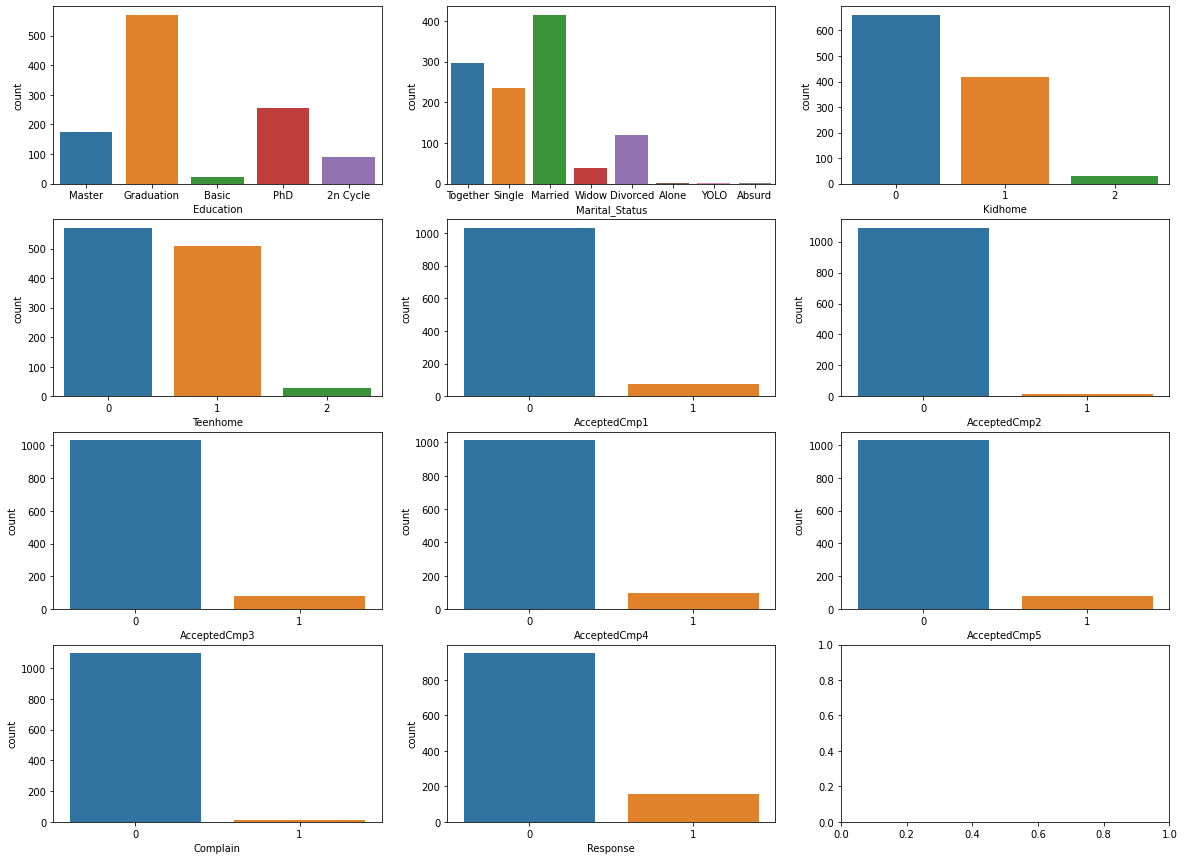

In [13]:
# 카테고리형 데이터 출력
fig, axes = plt.subplots(4, 3, figsize=(20, 15))

for ax,feature in zip(axes.flatten(), categorical):
    sns.countplot(data=train, x=feature, ax=ax)
plt.show()

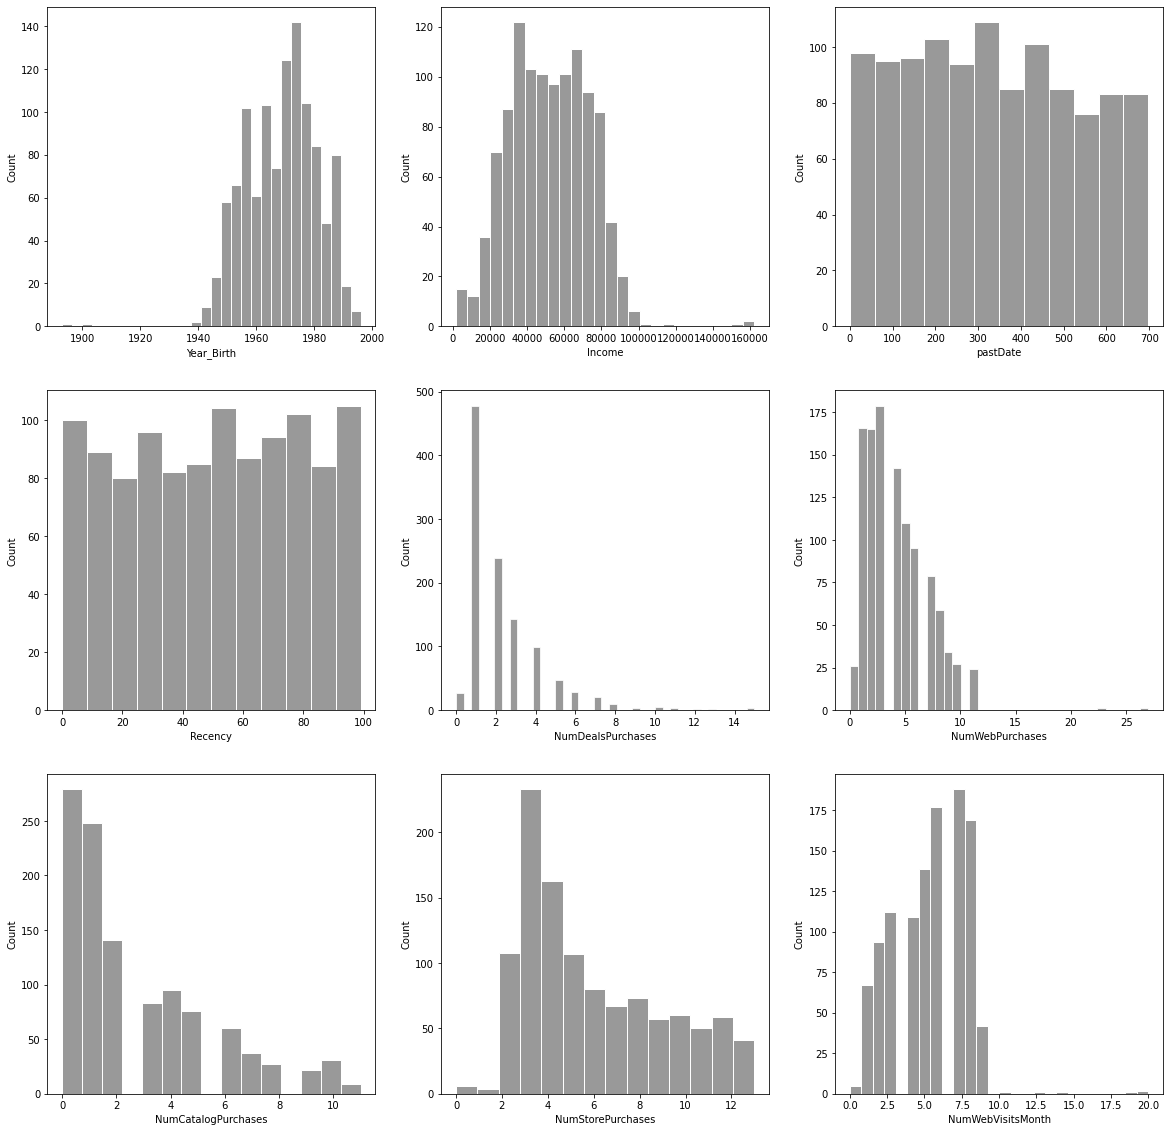

In [14]:
# 수치형 데이터 출력
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for ax, feature in zip(axes.flatten(), quantitative):
    sns.histplot(data=train, x=feature, ax=ax, color="#777777", edgecolor="#FFFFFF")
plt.show()

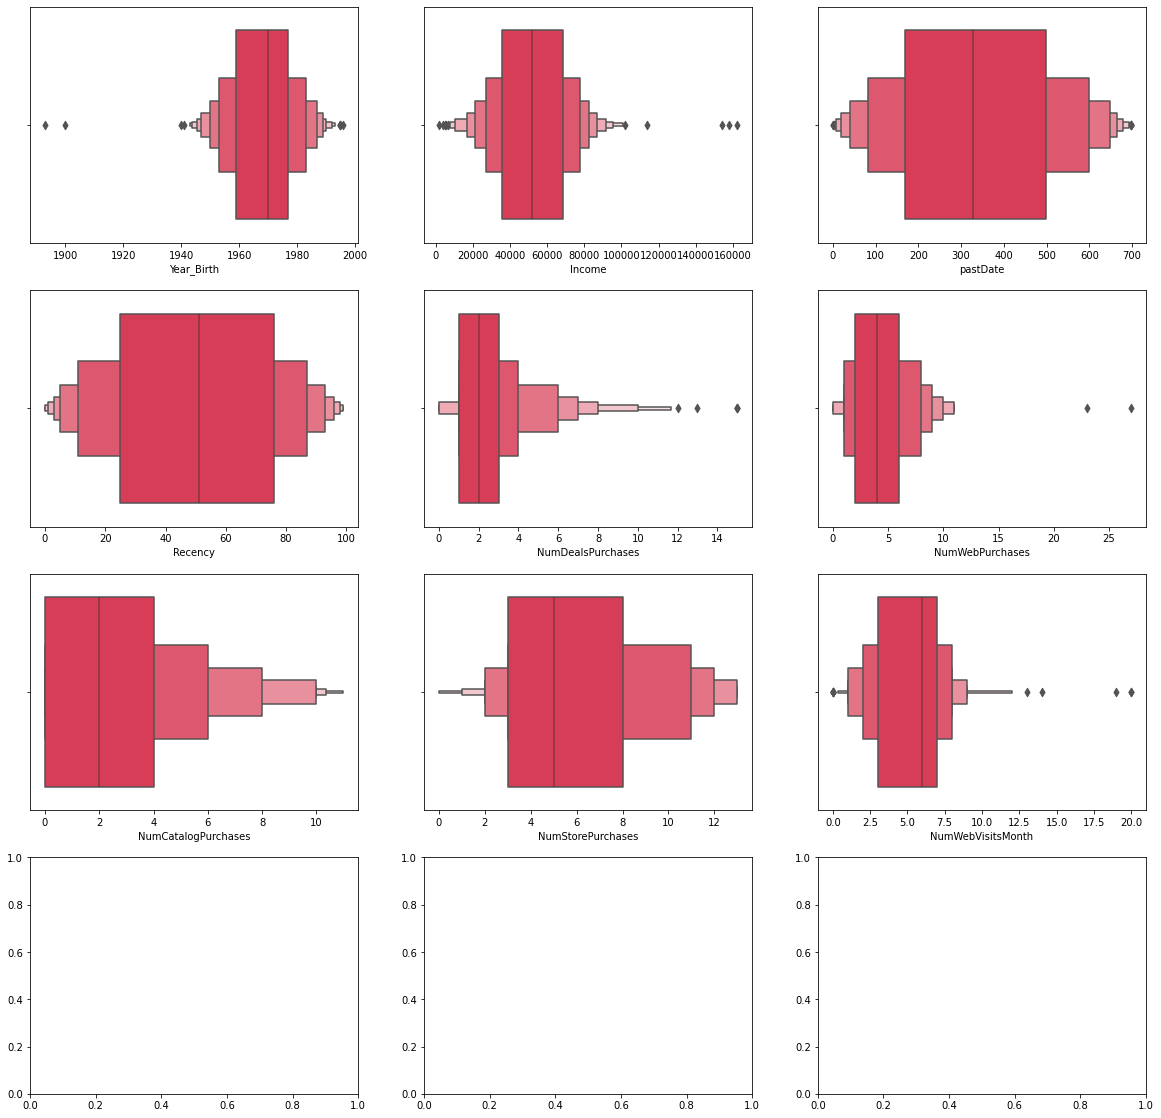

In [15]:
# outlier search
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for ax, feature in zip(axes.flatten(), quantitative):
    sns.boxenplot(data=train, x=feature, ax=ax, color="#f12345")
plt.show()

In [16]:
# Outlier 최대 제한선 탐색
# IQR : 사분위수 상위 75% 값 - 하위 25% 지점 값 차이 (Q3 - Q1)
from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    return lower_bound, upper_bound

['Year_Birth', 'Income', 'pastDate', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'target']
   Year_Birth   Income  pastDate  Recency  NumDealsPurchases  NumWebPurchases  \
0        1974  46014.0       174       21                 10                7   
1        1962  76624.0       662       68                  1                5   
2        1951  75903.0       251       50                  2                6   
3        1974  18393.0       606        2                  2                3   
4        1946  64014.0       679       56                  7                8   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  target  
0                    1                  8                  7     541  
1                   10                  7                  1     899  
2                    6                  9                  3     901  
3                    0                  3                  8      

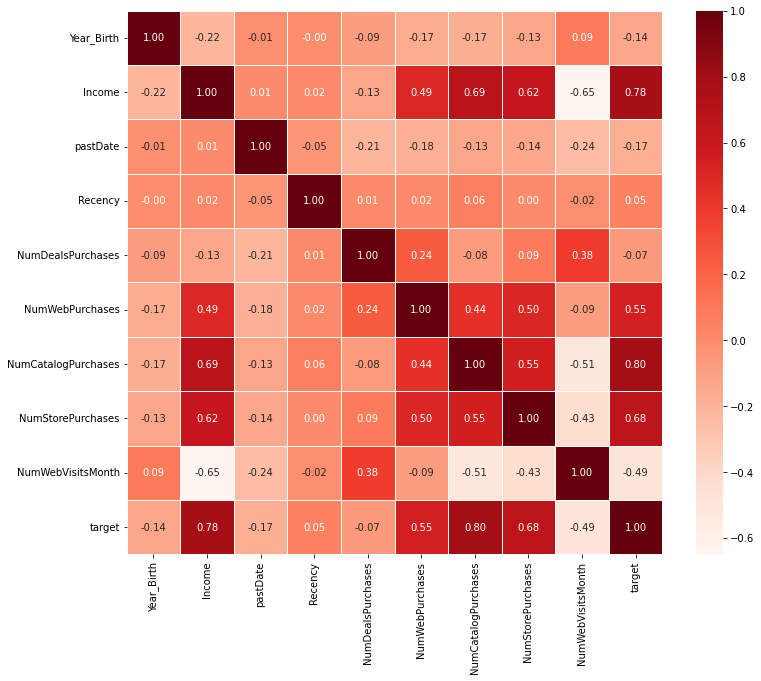

In [17]:
# corr 계수 확인
quantitative.append("target")

train_corr = train[quantitative]
print(quantitative)
print(train[quantitative].head())
print(train_corr.shape)
scaler = MinMaxScaler()
# 수치적 Data들 다 Normalization 때려버리네
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method="pearson")  # 피어슨 상관계수
plt.figure(figsize=(12, 10))
sns.heatmap(data=corr28, annot=True, fmt = ".2f", linewidths=.5, cmap="Reds")

print(corr28.shape)

In [18]:
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28["target"].sort_values(ascending=False), columns=["traget"])
df_temp28.style.background_gradient(cmap="viridis")

,traget
target,1.000000
NumCatalogPurchases,0.798065
Income,0.784084
NumStorePurchases,0.677785
NumWebPurchases,0.546082
Recency,0.050873
NumDealsPurchases,-0.072802
Year_Birth,-0.136035
pastDate,-0.174969
NumWebVisitsMonth,-0.488252


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  AcceptedCmp3         1108 non-null   int64  
 14  AcceptedCmp4         1108 non-null   int64  
 15  AcceptedCmp5         1108 non-null   i

In [20]:
# 카테고리형 데이터 Label encording
# label encording을 위한 dictionary 생성 함수
def make_label_map(dataframe):
    label_maps = dict()
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            label_map = dict() # {"unknown" : 0}
            for idx, key in enumerate(dataframe[col].unique()):
                label_map[key] = idx
            label_maps[col] = label_map
    return label_maps

# 각 카테고리형 변수에 encording 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            dataframe[col] = dataframe[col].map(label_map[col])
    return dataframe

print(make_label_map(train))  # "Education", "Marital_Status" 에 대해서만 처리
train = label_encoder(train, make_label_map(train))
train.head()

{'Education': {'Master': 0, 'Graduation': 1, 'Basic': 2, 'PhD': 3, '2n Cycle': 4}, 'Marital_Status': {'Together': 0, 'Single': 1, 'Married': 2, 'Widow': 3, 'Divorced': 4, 'Alone': 5, 'YOLO': 6, 'Absurd': 7}}


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,pastDate
0,0,1974,0,0,46014.0,1,1,21,10,7,...,7,0,0,0,0,0,0,0,541,174
1,1,1962,1,1,76624.0,0,1,68,1,5,...,1,1,0,0,0,0,0,0,899,662
2,2,1951,1,2,75903.0,0,1,50,2,6,...,3,0,0,0,0,0,0,0,901,251
3,3,1974,2,2,18393.0,1,0,2,2,3,...,8,0,0,0,0,0,0,0,50,606
4,4,1946,3,0,64014.0,2,1,56,7,8,...,7,0,0,0,1,0,0,0,444,679


In [21]:
data_test = label_encoder(data_test, make_label_map(data_test))
data_test.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,pastDate
0,0,1979,0,0,57537.0,1,0,83,4,4,...,8,4,0,0,0,0,0,0,0,315
1,1,1955,0,1,65748.0,0,1,58,2,2,...,10,1,0,0,0,0,0,1,0,259
2,2,1984,0,2,55434.0,1,0,21,3,5,...,13,4,0,0,0,0,0,0,0,432
3,3,1960,0,2,67716.0,0,1,8,4,7,...,13,5,0,1,0,0,0,0,0,164
4,4,1976,0,1,85606.0,0,1,89,2,6,...,9,3,0,0,0,1,0,0,0,105


In [22]:
data = train.copy()
data

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,pastDate
0,0,1974,0,0,46014.0,1,1,21,10,7,...,7,0,0,0,0,0,0,0,541,174
1,1,1962,1,1,76624.0,0,1,68,1,5,...,1,1,0,0,0,0,0,0,899,662
2,2,1951,1,2,75903.0,0,1,50,2,6,...,3,0,0,0,0,0,0,0,901,251
3,3,1974,2,2,18393.0,1,0,2,2,3,...,8,0,0,0,0,0,0,0,50,606
4,4,1946,3,0,64014.0,2,1,56,7,8,...,7,0,0,0,1,0,0,0,444,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1103,1956,1,0,46097.0,0,1,11,5,3,...,4,0,0,0,0,0,0,0,241,243
1104,1104,1986,1,2,23477.0,1,0,39,3,3,...,8,0,0,0,0,0,0,0,147,447
1105,1105,1975,0,2,37368.0,1,0,4,1,1,...,6,1,0,0,0,0,0,0,30,503
1106,1106,1974,1,4,53034.0,1,1,30,8,6,...,8,0,0,0,0,0,0,0,447,303


#### 전처리 파트

In [23]:
## 상관계수 낮은 데이터 다 Drop
data.drop(["Recency", "NumDealsPurchases", "id"], axis=1, inplace=True)
data_test.drop(["Recency", "NumDealsPurchases", "id"], axis=1, inplace=True)
##

## 캠프 통합
data["AcceptCount"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"] + data["Response"]
data_test["AcceptCount"] = data_test["AcceptedCmp1"] + data_test["AcceptedCmp2"] + data_test["AcceptedCmp3"] + data_test["AcceptedCmp4"] + data_test["AcceptedCmp5"] + data_test["Response"]

# data["isCamp"] = np.where(data["AcceptCount"], 1, 0)
# data_test["isCamp"] = np.where(data_test["AcceptCount"], 1, 0)

data.drop(["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1, inplace=True)
data_test.drop(["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"], axis=1, inplace=True)
##

## Education의 basic을 2n_cycle로 편입 (임시 보류)
data["Education"] = np.where(data["Education"] == 4, 2, data["Education"])
data_test["Education"] = np.where(data_test["Education"] == 4, 2, data_test["Education"])
##

## Marital_Status Yolo, Alone, Absure을 Single로 편입
data["Marital_Status"] = np.where(data["Marital_Status"] > 4, 1, data["Marital_Status"])
data_test["Marital_Status"] = np.where(data_test["Marital_Status"] > 4, 1, data_test["Marital_Status"])
##

## Kidhome, Teenhome 축소. 자녀의 유무만 표현
# tempVector = [0 for _ in range(data.shape[0])]
# for idx, item in enumerate(data["Kidhome"]):
#     if item == 2:
#         tempVector[idx] = 1
#     else:
#         tempVector[idx] = item
# data["isKid"] = tempVector
# data.drop(["Kidhome", "Teenhome"], axis=1, inplace=True)

data["Kidhome"] = np.where(data["Kidhome"] == 2, 1, data["Kidhome"])
data["Teenhome"] = np.where(data["Teenhome"] == 2, 1, data["Teenhome"])
tempVector = [0 for _ in range(data.shape[0])]
for col in data.columns:
    if "Kidhome" in col:
        for idx, element in enumerate(zip(tempVector, data[col])):
            tempVector[idx] = element[0] or element[1]
    if "Teenhome" in col:
        for idx, element in enumerate(zip(tempVector, data[col])):
            tempVector[idx] = element[0] or element[1]
data["isKid"] = tempVector

data_test["Kidhome"] = np.where(data_test["Kidhome"] == 2, 1, data_test["Kidhome"])
data_test["Teenhome"] = np.where(data_test["Teenhome"] == 2, 1, data_test["Teenhome"])
tempVector = [0 for _ in range(data_test.shape[0])]
for col in data_test.columns:
    if "Kidhome" in col:
        for idx, element in enumerate(zip(tempVector, data_test[col])):
            tempVector[idx] = element[0] or element[1]
    if "Teenhome" in col:
        for idx, element in enumerate(zip(tempVector, data_test[col])):
            tempVector[idx] = element[0] or element[1]
data_test["isKid"] = tempVector
##

print("data set : ", data.shape)
print("data_test set : ", data_test.shape)

data set :  (1108, 15)
data_test set :  (1108, 14)


#### 전처리 실험실

In [24]:

# tempVector = [0 for _ in range(data.shape[0])]
# for idx, item in enumerate(data["Kidhome"]):
#     if item == 2:
#         tempVector[idx] = 1
#     else:
#         tempVector[idx] = item
# data["isKid"] = tempVector

# sns.countplot(data=data, x="isKid")
# plt.show()
# ################################################# 두개가 같음
# data["Kidhome"] = np.where(data["Kidhome"] == 2, 1, data["Kidhome"])

# sns.countplot(data=data, x="Kidhome")
# plt.show()

In [25]:
corr_matrix = data.corr()
corr_matrix["target"].sort_values(ascending=False)

target                 1.000000
NumCatalogPurchases    0.798065
Income                 0.784084
NumStorePurchases      0.677785
NumWebPurchases        0.546082
AcceptCount            0.444114
Marital_Status         0.030707
Education              0.017247
Complain              -0.058704
Teenhome              -0.124089
Year_Birth            -0.136035
pastDate              -0.174969
NumWebVisitsMonth     -0.488252
isKid                 -0.502295
Kidhome               -0.556375
Name: target, dtype: float64

In [26]:
data

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,target,pastDate,AcceptCount,isKid
0,1974,0,0,46014.0,1,1,7,1,8,7,0,541,174,0,1
1,1962,1,1,76624.0,0,1,5,10,7,1,0,899,662,1,1
2,1951,1,2,75903.0,0,1,6,6,9,3,0,901,251,0,1
3,1974,2,2,18393.0,1,0,3,0,3,8,0,50,606,0,1
4,1946,3,0,64014.0,1,1,8,2,5,7,0,444,679,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1956,1,0,46097.0,0,1,3,1,6,4,0,241,243,0,1
1104,1986,1,2,23477.0,1,0,3,0,4,8,0,147,447,0,1
1105,1975,0,2,37368.0,1,0,1,0,2,6,0,30,503,1,1
1106,1974,1,4,53034.0,1,1,6,1,7,8,0,447,303,0,1


In [27]:
# 균일한 분할을 위한 target range 생성
data_T = data["target"]
target = list()
for idx in range(len(data_T)):
    if data_T.iloc[idx] < 250:
        target.append(1)
    elif data_T.iloc[idx] < 1000:
        target.append(2)
    elif data_T.iloc[idx] < 1800:
        target.append(3)
    else:
        target.append(4)

data["Range"] = target

In [28]:
# train package import
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

In [29]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,target,pastDate,AcceptCount,isKid,Range
0,1974,0,0,46014.0,1,1,7,1,8,7,0,541,174,0,1,2
1,1962,1,1,76624.0,0,1,5,10,7,1,0,899,662,1,1,2
2,1951,1,2,75903.0,0,1,6,6,9,3,0,901,251,0,1,2
3,1974,2,2,18393.0,1,0,3,0,3,8,0,50,606,0,1,1
4,1946,3,0,64014.0,1,1,8,2,5,7,0,444,679,1,1,2


In [30]:
data_train_X = data.drop(["target"], axis=1)
data_train_X.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,pastDate,AcceptCount,isKid,Range
0,1974,0,0,46014.0,1,1,7,1,8,7,0,174,0,1,2
1,1962,1,1,76624.0,0,1,5,10,7,1,0,662,1,1,2
2,1951,1,2,75903.0,0,1,6,6,9,3,0,251,0,1,2
3,1974,2,2,18393.0,1,0,3,0,3,8,0,606,0,1,1
4,1946,3,0,64014.0,1,1,8,2,5,7,0,679,1,1,2


In [31]:
data_train_y = data.target
data_train_y.head()

0    541
1    899
2    901
3     50
4    444
Name: target, dtype: int64

In [32]:
# train
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
n = 0

fold_target_pred = list()
fold_score = list()

# subsample_rate = 0.3
# subsample_count = (int)(len(data) * subsample_rate)
# estimator_count = 300
# learning_rate = 0.1

for train_index, valid_index in skf.split(data_train_X, data_train_X["Range"]):
    n += 1
    
    val_pred_name = list()
    val_pred = list()
    target_pred = list()
    
    train_X = np.array(data_train_X.drop("Range", axis=1))
    train_y = np.array(data_train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_y[train_index], train_y[valid_index]
    
    X_test = np.array(data_test)
    
#     # LinearRegressor
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     val_pred_name.append("LinearRegression")
#     val_pred.append(model.predict(X_valid))
#     target_pred.append(model.predict(X_test))
    
#     # AdaBoostRegressor
#     model = AdaBoostRegressor(n_estimators=estimator_count, learning_rate=learning_rate, random_state=777)
#     model.fit(X_train, y_train)
#     val_pred_name.append("AdaBoostRegressor")
#     val_pred.append(model.predict(X_valid))
#     target_pred.append(model.predict(X_test))
    
    # RandomForestRegressor
#     model = RandomForestRegressor(max_samples=subsample_count, n_estimators=estimator_count, random_state=777)
    model = RandomForestRegressor(n_estimators=200, max_depth=16, random_state=777)
    model.fit(X_train, y_train)
    val_pred_name.append("RandomForestRegressor")
    val_pred.append(model.predict(X_valid))
    target_pred.append(model.predict(X_test))
    
    # LGBMRegressor
#     model = LGBMRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777)
    model = LGBMRegressor(n_estimators=150, max_depth=16, random_state=777)
    model.fit(X_train, y_train)
    val_pred_name.append("LGBMRegressor")
    val_pred.append(model.predict(X_valid))
    target_pred.append(model.predict(X_test))
    
#     # GradientBoostingRegressor
#     model = GradientBoostingRegressor(n_estimators=1200, max_depth=8, learning_rate=0.01, criterion="mae", random_state=777)
#     model.fit(X_train, y_train)
#     val_pred_name.append("GradientBoostingRegressor")
#     val_pred.append(model.predict(X_valid))
#     target_pred.append(model.predict(X_test))
    
    # XGBRegressor
#     model = XGBRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777)
    model = XGBRegressor(n_estimators=200, max_depth=8, random_state=777)
    model.fit(X_train, y_train)
    val_pred_name.append("XGBRegressor")
    val_pred.append(model.predict(X_valid))
    target_pred.append(model.predict(X_test))
    
    # CatBoostRegressor
    model = CatBoostRegressor(n_estimators=1200, max_depth=8, silent=True, random_state=777)
    model.fit(X_train, y_train)
    val_pred_name.append("CatBoostRegressor")
    val_pred.append(model.predict(X_valid))
    target_pred.append(model.predict(X_test))
    
    ### voting
    preds = np.array(val_pred[0])
    for idx in range(1, len(val_pred)):
        preds += val_pred[idx]
    
    preds = preds/len(val_pred)
    
    target_preds = np.array(target_pred[0])
    for idx in range(1, len(target_pred)):
        target_preds += target_pred[idx]
    
    target_preds = target_preds/len(target_pred)
    
    fold_target_pred.append(target_preds)
    
    print("=============== fold %d ===============" % n)
    for idx in range(len(val_pred)):
        print("%s model NMAE : %0.7f" % (val_pred_name[idx], NMAE(y_valid, val_pred[idx].astype(int))))
    
    print("=======================================")
    print("Average NMAE %0.7f" % (NMAE(y_valid, preds.astype(int))))
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))

total_score = fold_score[0]
for idx in range(2, len(fold_score), 1):
    total_score += fold_score[idx]
total_score = total_score/len(fold_score)

print("=======================================")
print("Total Average NMAE %0.7f" % total_score)

=============== fold 1 ===============
RandomForestRegressor model NMAE : 0.1987804
LGBMRegressor model NMAE : 0.2016019
XGBRegressor model NMAE : 0.2036346
CatBoostRegressor model NMAE : 0.2082916
Average NMAE 0.1926974

=============== fold 2 ===============
RandomForestRegressor model NMAE : 0.1832720
LGBMRegressor model NMAE : 0.1880743
XGBRegressor model NMAE : 0.1868891
CatBoostRegressor model NMAE : 0.1794548
Average NMAE 0.1758531

=============== fold 3 ===============
RandomForestRegressor model NMAE : 0.1463160
LGBMRegressor model NMAE : 0.1650411
XGBRegressor model NMAE : 0.1354377
CatBoostRegressor model NMAE : 0.1503080
Average NMAE 0.1379069

=============== fold 4 ===============
RandomForestRegressor model NMAE : 0.1807355
LGBMRegressor model NMAE : 0.1770579
XGBRegressor model NMAE : 0.1969401
CatBoostRegressor model NMAE : 0.1803189
Average NMAE 0.1733803

=============== fold 5 ===============
RandomForestRegressor model NMAE : 0.1998260
LGBMRegressor model NMAE : 0

- 0.1632668 - 0.5 500 0.1 (rf lgbm xgb catb)
- 0.1621467 - 0.75 1000 0.1 (rf lgbm xgb catb)
- 0.1714536 - 0.75 1000 0.1 (adab rf lgbm xgb catb) -> adaboost가 성능이 좀 밀림
- 0.1689079 - 0.75 1000 0.1 (lr rf lgbm gb xgb catb) -> linear 성능이 좀;
- 0.1609458 - 0.75 1000 0.1 (rf lgbm gb xgb catb)
- 0.1610123 - 0.75 500 0.1 (rf lgbm gb xgb catb)
- 0.1635321 - 0.5 1000 0.1 (rf lgbm gb xgb catb)
- 0.1596425 - isKid feature 추가 (0.75 500 0.1 (rf lgbm gb xgb catb))
- 0.1601764 - 0.75 500 0.1 (rf, lgbm, xgb, catb)
- 0.1565269 - pastDate 수정 0.75 500 0.1 (rf, lgbm, xgb, catb)
- 0.1566882 - 캠프참가 횟수로 수정 0.75 500 0.1 (rf, lgbm xgb, catb)
- 0.1574497 - 0.5 500 0.1 (rf, lgbm xgb, catb)
- 0.1588569 - 0.3 500 0.1 (rf, lbgm, xgb, catb)
- 0.1591359 - 0.3 300 0.1 (rf, lbgm, xgb, catb)
- 0.1593729 - 캠프 참가여부 추가 0.3 300 0.1 (rf, lgm, xgb, catb) -> 비효율적
- 0.1578233 - all default (rf, lgm, xgb, catb)
- 0.1551230 - 규제 추가
- 규제추가 + gb추가 -> 너무느려서 측정중단

In [33]:
final_pred = np.array(fold_target_pred[0])
for idx in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[idx]
    
final_pred = final_pred/len(fold_target_pred)
final_pred = final_pred.astype(int)

submission = pd.read_csv("./sample_submission.csv")
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [34]:
submission["target"] = final_pred
submission.head()

,id,target
0,0,528
1,1,793
2,2,845
3,3,1302
4,4,1396


In [35]:
submission.to_csv("Submit.csv", index=False)

In [36]:
# ## train_test_split
# train_data, val_data = train_test_split(data, test_size=0.2)
# train_data.reset_index(inplace=True)
# val_data.reset_index(inplace=True)
# print("train set : ", train_data.shape)
# print("validation set : ", val_data.shape)

# train_data_X = train_data.drop(["target", "index"], axis=1)
# train_data_y = train_data.target

# val_data_X = val_data.drop(["target", "index"], axis=1)
# val_data_y = val_data.target

# print(train_data_X.shape, train_data_y.shape, val_data_X.shape, val_data_y.shape)
# ##

# models = list()

# subsample_rate = 0.75
# subsample_count = (int)(len(train_data_X) * subsample_rate)
# estimator_count = 300
# learning_rate = 0.07

# models.append(LinearRegression())
# models.append(AdaBoostRegressor(n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))
# models.append(RandomForestRegressor(max_samples=subsample_count, n_estimators=estimator_count, random_state=777))
# models.append(GradientBoostingRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, criterion="mae", random_state=777))
# models.append(XGBRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))
# models.append(LGBMRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))

# #model.fit(train_data_X, train_data_y)
# for model in models:
#     model.fit(train_data_X, train_data_y)

# # Ensenble(Soft Voting)
# prediction = None

# for model in models:
#     if prediction is None:
#         prediction = model.predict(val_data_X)
#     else:
#         prediction += model.predict(val_data_X)
        
# # 앙상블에 참여한 모델 숫자만큼 결과 나눠줌 (평균값 취함)
# prediction /= len(models)

In [37]:
# models

In [38]:
# prediction[:10]

In [39]:
# import numpy as np
# from sklearn.metrics import mean_squared_error

# def nmae(true, pred):
#     mae = np.mean(np.abs(true-pred))
#     score = mae / np.mean(np.abs(true))
    
#     return score

# y_hat = model.predict(val_data_X)
# print("NMAE : {}".format(nmae(val_data_y, y_hat)))

In [40]:
# plt.style.use("ggplot")
# plt.figure(figsize=(20, 10))
# plt.plot(y_hat, label="predicton")
# plt.plot(val_data_y, label = "real")
# plt.legend(fontsize = 20)
# plt.show()

In [41]:
# data

### Dacon 대회 제출용 코드

#### Train set + Validation set 100% 활용 모델

In [42]:
# train_X = data.drop(["target"], axis=1)
# train_y = data.target

# models = list()

# subsample_rate = 0.5
# subsample_count = (int)(len(train_X) * subsample_rate)
# estimator_count = 1000
# learning_rate = 0.1

# models.append(LinearRegression())
# models.append(AdaBoostRegressor(n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))
# models.append(RandomForestRegressor(max_samples=subsample_count, n_estimators=estimator_count, random_state=777))
# models.append(GradientBoostingRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, criterion="mae", random_state=777))
# models.append(xgboost.XGBRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))
# models.append(lgb.LGBMRegressor(subsample=subsample_rate, n_estimators=estimator_count, learning_rate=learning_rate, random_state=777))

# for model in models:
#     model.fit(train_X, train_y)

In [43]:
# train_X

In [44]:
# train_y

In [45]:
# # test data도 전처리
# test = pd.read_csv("test.csv")
# year, month, day = seperate_datetime(test)
# test =test.drop("Dt_Customer", axis=1)

# year = [2022 - item for item in year]
# year = [365 * item for item in year]
# month = [30 * item for item in month]
# pastDate = [item[0] + item[1] + item[2] for item in zip(year, month, day)]

# print(year[:10])
# print(month[:10])
# print(day[:10])
# print(pastDate[:10])

# test["pastDate"] = pastDate

# test["year"] = year
# test["month"] = month
# test["day"] = day

# test = label_encoder(test,make_label_map(test))
# test = test.drop(["id"], axis = 1)

# ## 상관계수 낮은 데이터 다 Drop
# test.drop(["Recency", "month", "day", "NumDealsPurchases"], axis=1, inplace=True)
# ##

# ## 캠프 통합 (참가? 비참가?)
# tempVector = [0 for _ in range(test.shape[0])]
# for col in test.columns:
#     if "AcceptedCmp" in col:
#         for idx, element in enumerate(zip(tempVector, test[col])):
#             tempVector[idx] = element[0] or element[1]

# test["AcceptedCmp"] = tempVector
# test.drop(["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"], axis=1, inplace=True)
# ##

# ## Marital_Status Yolo, Alone, Absure을 Single로 편입
# tempVector = [0 for _ in range(test.shape[0])]
# for idx, item in enumerate(test["Marital_Status"]):
#     if item > 4:
#         tempVector[idx] = 1
#     else:
#         tempVector[idx] = item

# test["Marital_Status"] = tempVector
# ##

# ## Kidhome, Teenhome 축소. 자녀의 유무만 표현
# tempVector = [0 for _ in range(test.shape[0])]
# for idx, item in enumerate(test["Kidhome"]):
#     if item == 2:
#         tempVector[idx] = 1
#     else:
#         tempVector[idx] = item
# test["isKid"] = tempVector
# test.drop(["Kidhome", "Teenhome"], axis=1, inplace=True)
# ##

# print(test.shape)
# test.head()

In [46]:
# pred = None
# for model in models:
#     if pred is None:
#         pred = model.predict(test)
#     else:
#         pred += model.predict(test)

# pred /= len(models)

In [47]:
# pred[:10]

In [48]:
# submission = pd.read_csv("./sample_submission.csv")
# print(submission.shape)
# submission.head()

In [49]:
# submission["target"] = pred
# submission.head()

In [50]:
# submission.to_csv("submission_baseline2.csv", index=False)